In [1]:
library("dplyr")
library("magrittr")
library("igraph")
library("plyr")
library("ggplot2")
library("ggfortify")
library("pheatmap")
library("readxl")
library("tidyverse")
library("WriteXLS")
library("parallel")


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘igraph’

The following objects are masked from ‘package:dplyr’:

    as_data_frame, groups, union

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

------------------------------------------------------------------------------
You have loaded plyr after dplyr - this is likely to cause problems.
If you need functions from both plyr and dplyr, please load plyr first, then dplyr:
library(plyr); library(dplyr)
------------------------------------------------------------------------------

Attaching package: ‘plyr’

The following objects are masked from ‘package:dplyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize

── Attaching packages ────────

In [2]:
source("R/Helper.R")
source("R/Plotting.R")

In [3]:
deg_genes_corr <- readRDS("../results/correlation/deg_genes/deg_genes_corr.rds")

In [91]:
outdir <- "../results/correlation/deg_genes/distribution_plots/"
dir.create(outdir)

Warning message in dir.create(outdir):
“'../results/correlation/deg_genes/distribution_plots' already exists”

In [10]:
dim(deg_genes_corr$Afu_alone_0h$p$p)

[1] 523 523

## Number of genes per condition

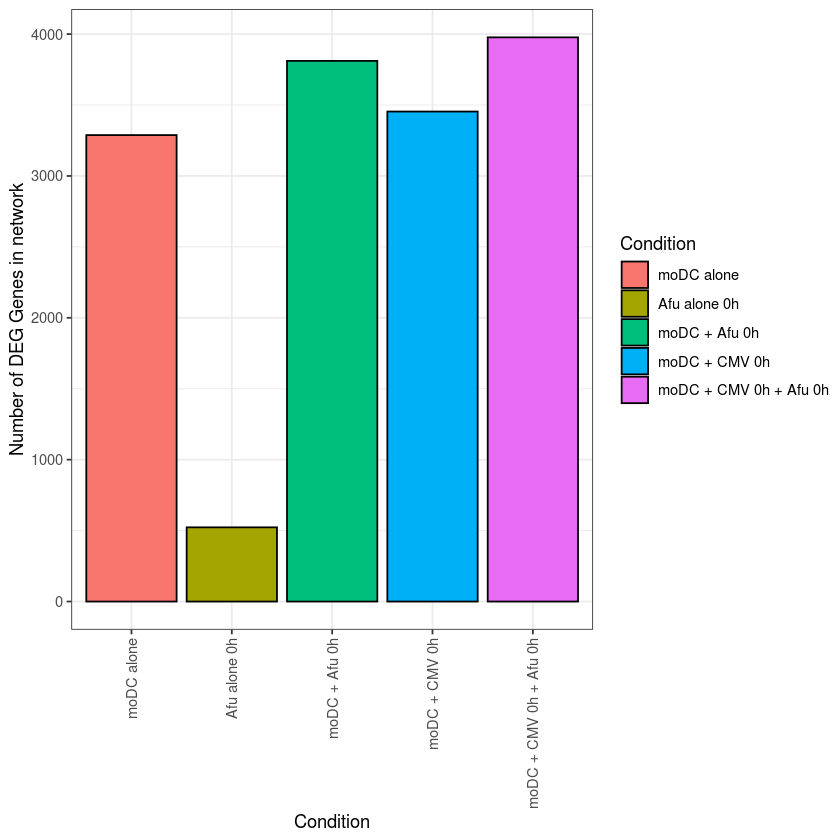

In [88]:
n_genes <- plyr::ldply(deg_genes_corr, .id = "Condition", function(x) data.frame(`Number of DEG Genes in network` = nrow(x$p$p), check.names = F))
                       
g <- n_genes %>%
    mutate(Condition = str_replace_all(Condition, "_", " ") %>% str_replace_all("plus", "+")) %>%
    mutate(Condition = factor(Condition,
                              levels = c("DC alone", "Afu alone 0h", "DC + Afu 0h", "DC + CMV 0h", "DC + CMV 0h + Afu 0h"),
                              label  = c("moDC alone", "Afu alone 0h", "moDC + Afu 0h", "moDC + CMV 0h", "moDC + CMV 0h + Afu 0h"))) %>%
    ggplot(aes(x = Condition, y = `Number of DEG Genes in network`, fill = Condition)) +
    geom_bar(stat = "identity", color = "black") +
    theme_bw() +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1))
g

In [92]:
ggsave(paste0(outdir, "num_genes_per_network.pdf"), g, scale = 1)

Saving 6.67 x 6.67 in image


In [33]:
lapply(deg_genes_corr, function(x) sum(is.na(x$p$p)))

$Afu_alone_0h
[1] 4164

$DC_alone
[1] 1107546

$DC_plus_Afu_0h
[1] 506118

$DC_plus_CMV_0h
[1] 199462

$DC_plus_CMV_0h_plus_Afu_0h
[1] 39740

## Distribution of P- and Rho-values per Condition

In [16]:
# return upper triangle of p and rho values (per group)
corr_p_list <- lapply(deg_genes_corr, function(x) x$p$p[upper.tri(x$p$p)])
corr_r_list <- lapply(deg_genes_corr, function(x) x$r[upper.tri(x$r)])

In [20]:
corr_p <- plyr::ldply(corr_p_list, function(x) data.frame(p = x))

In [50]:
corr_r <- plyr::ldply(corr_r_list, function(x) data.frame(r = x))

In [62]:
head(corr_r)

.id,r
<chr>,<dbl>
Afu_alone_0h,0.7775410
Afu_alone_0h,0.7390794
Afu_alone_0h,0.7229483
Afu_alone_0h,0.9456706
Afu_alone_0h,0.5362384
Afu_alone_0h,0.5774804


In [63]:
corr_p %>% group_by(`.id`) %>% dplyr::summarize(Valid = sum(!is.na(p)), Invalid = sum(is.na(p))) %>% print()
print("Should be identical to...")
corr_r %>% group_by(`.id`) %>% dplyr::summarize(Valid = sum(!is.na(r)), Invalid = sum(is.na(r))) %>% print()

# A tibble: 5 x 3
  .id                          Valid Invalid
  <chr>                        <int>   <int>
1 Afu_alone_0h                134421    2082
2 DC_alone                   4850055  553773
3 DC_plus_Afu_0h             7006896  253059
4 DC_plus_CMV_0h             5863600   99731
5 DC_plus_CMV_0h_plus_Afu_0h 7886406   19870
[1] ""
# A tibble: 5 x 3
  .id                          Valid Invalid
  <chr>                        <int>   <int>
1 Afu_alone_0h                134421    2082
2 DC_alone                   4850055  553773
3 DC_plus_Afu_0h             7006896  253059
4 DC_plus_CMV_0h             5863600   99731
5 DC_plus_CMV_0h_plus_Afu_0h 7886406   19870


In [41]:
g <- ggplot(corr_p, aes(p, fill = `.id`, color = `.id`)) +
    facet_wrap(~ `.id`, scales = "free", nrow = 1) +
    geom_histogram(bins = 1000) +
    ggtitle("P-value Distribution") +
    theme_bw()

Warning message:
“Removed 928515 rows containing non-finite values (stat_bin).”

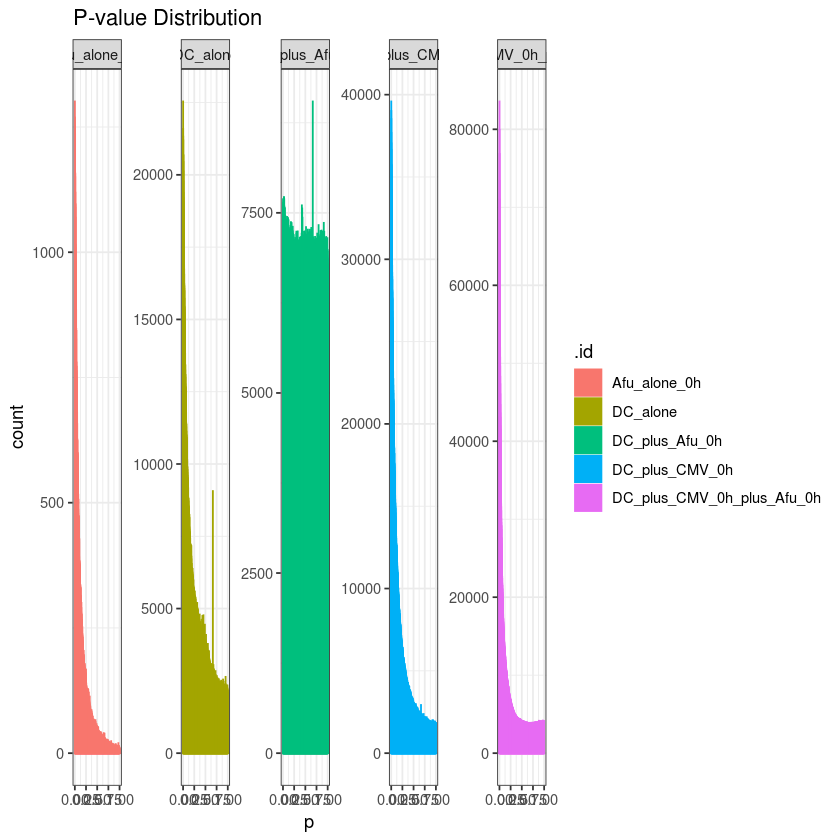

In [42]:
g

In [43]:
ggsave(paste0(outdir, "/p_value_distribution.pdf"), g, width = 14, height = 7)

Warning message:
“Removed 928515 rows containing non-finite values (stat_bin).”

In [52]:
g <- ggplot(corr_r, aes(r, fill = `.id`, color = `.id`)) +
    facet_wrap(~ `.id`, scales = "free", nrow = 1) +
    geom_histogram(bins = 1000) +
    ggtitle("Rho Distribution") +
    theme_bw()

Warning message:
“Removed 928515 rows containing non-finite values (stat_bin).”

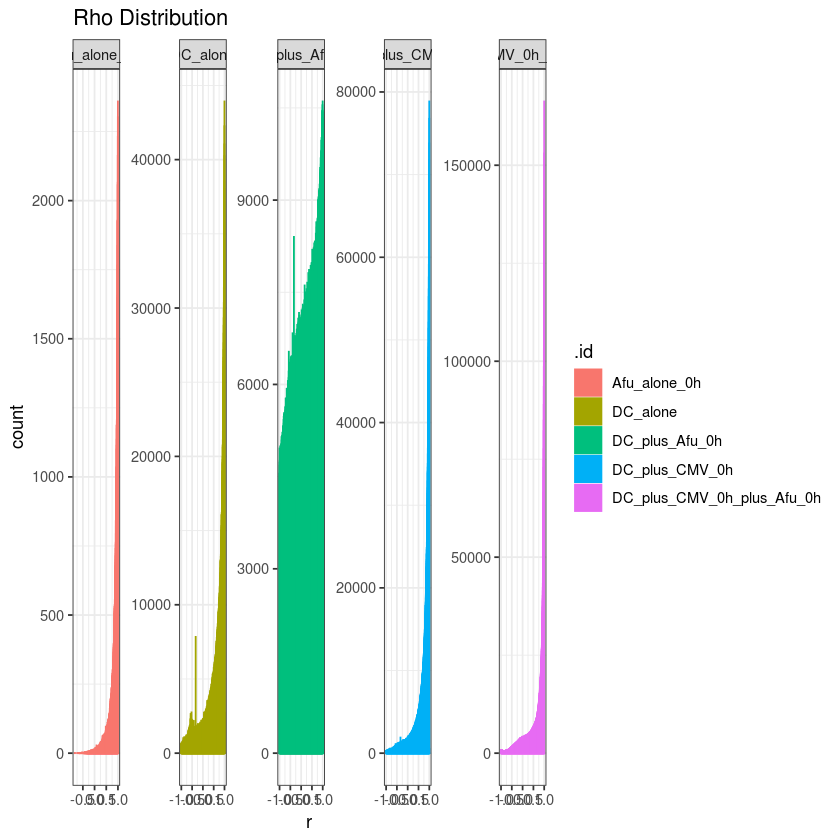

In [53]:
g

In [54]:
ggsave(paste0(outdir, "/rho_value_distribution.pdf"), g, width = 14, height = 7)

Warning message:
“Removed 928515 rows containing non-finite values (stat_bin).”

## Distribution of P- and Rho-values for significant edges

In [ ]:
gene_corr_res_sig005 <- llply(gene_corr_res, function(lmat) {
    # set unsignificant rho to 0
    lmat$r[is.na(lmat$p$p) | lmat$p$p >= 0.05] <- 0.0
    lmat
})

gene_corr_res_sig001 <- llply(gene_corr_res, function(lmat) {
    # set unsignificant rho to 0
    lmat$r[is.na(lmat$p$p) | lmat$p$p >= 0.01] <- 0.0
    lmat
})

gene_corr_res_sig0001 <- llply(gene_corr_res, function(lmat) {
    # set unsignificant rho to 0
    lmat$r[is.na(lmat$p$p) | lmat$p$p >= 0.001] <- 0.0
    lmat
})

gene_corr_res_sig000 <- llply(gene_corr_res, function(lmat) {
    # set unsignificant rho to 0
    lmat$r[is.na(lmat$p$p) | lmat$p$p > 0.0] <- 0.0
    lmat
})

In [ ]:
lmat <- gene_corr_res_sig000$Afu_alone_0h
sum(is.na(lmat$p$p) | lmat$p$p >= 0.01)
sum(!is.na(lmat$p$p) & lmat$p$p < 0.01)

In [ ]:
# We learn:
#  Once the p-value filter is applied, a rho filter is not necessary anymore

# get some stats
reduce(.f = merge, .x = list(
          ldply(gene_corr_res, function(l) data.frame("r0.00" = sum(abs(l$r) > 0.00, na.rm = T))),
          ldply(gene_corr_res, function(l) data.frame("r0.25" = sum(abs(l$r) > 0.25, na.rm = T))),
          ldply(gene_corr_res, function(l) data.frame("r0.50" = sum(abs(l$r) > 0.50, na.rm = T))),
          ldply(gene_corr_res, function(l) data.frame("r0.75" = sum(abs(l$r) > 0.75, na.rm = T))),
          ldply(gene_corr_res, function(l) data.frame("r0.90" = sum(abs(l$r) > 0.90, na.rm = T))),
          ldply(gene_corr_res, function(l) data.frame("r0.95" = sum(abs(l$r) > 0.95, na.rm = T)))
      )
)

# get some stats
reduce(.f = merge, .x = list(
          ldply(gene_corr_res_sig005, function(l) data.frame("r0.00" = sum(abs(l$r) > 0.00, na.rm = T))),
          ldply(gene_corr_res_sig005, function(l) data.frame("r0.25" = sum(abs(l$r) > 0.25, na.rm = T))),
          ldply(gene_corr_res_sig005, function(l) data.frame("r0.50" = sum(abs(l$r) > 0.50, na.rm = T))),
          ldply(gene_corr_res_sig005, function(l) data.frame("r0.75" = sum(abs(l$r) > 0.75, na.rm = T))),
          ldply(gene_corr_res_sig005, function(l) data.frame("r0.90" = sum(abs(l$r) > 0.90, na.rm = T))),
          ldply(gene_corr_res_sig005, function(l) data.frame("r0.95" = sum(abs(l$r) > 0.95, na.rm = T)))
      )
)

# get some stats
reduce(.f = merge, .x = list(
          ldply(gene_corr_res_sig001, function(l) data.frame("r0.00" = sum(abs(l$r) > 0.00, na.rm = T))),
          ldply(gene_corr_res_sig001, function(l) data.frame("r0.25" = sum(abs(l$r) > 0.25, na.rm = T))),
          ldply(gene_corr_res_sig001, function(l) data.frame("r0.50" = sum(abs(l$r) > 0.50, na.rm = T))),
          ldply(gene_corr_res_sig001, function(l) data.frame("r0.75" = sum(abs(l$r) > 0.75, na.rm = T))),
          ldply(gene_corr_res_sig001, function(l) data.frame("r0.90" = sum(abs(l$r) > 0.90, na.rm = T))),
          ldply(gene_corr_res_sig001, function(l) data.frame("r0.95" = sum(abs(l$r) > 0.95, na.rm = T)))
      )
)
                
reduce(.f = merge, .x = list(
          ldply(gene_corr_res_sig0001, function(l) data.frame("r0.00" = sum(abs(l$r) > 0.00, na.rm = T))),
          ldply(gene_corr_res_sig0001, function(l) data.frame("r0.25" = sum(abs(l$r) > 0.25, na.rm = T))),
          ldply(gene_corr_res_sig0001, function(l) data.frame("r0.50" = sum(abs(l$r) > 0.50, na.rm = T))),
          ldply(gene_corr_res_sig0001, function(l) data.frame("r0.75" = sum(abs(l$r) > 0.75, na.rm = T))),
          ldply(gene_corr_res_sig0001, function(l) data.frame("r0.90" = sum(abs(l$r) > 0.90, na.rm = T))),
          ldply(gene_corr_res_sig0001, function(l) data.frame("r0.95" = sum(abs(l$r) > 0.95, na.rm = T)))
      )
)
                
# get some stats
reduce(.f = merge, .x = list(
          ldply(gene_corr_res_sig000, function(l) data.frame("r0.00" = sum(abs(l$r) > 0.00, na.rm = T))),
          ldply(gene_corr_res_sig000, function(l) data.frame("r0.25" = sum(abs(l$r) > 0.25, na.rm = T))),
          ldply(gene_corr_res_sig000, function(l) data.frame("r0.50" = sum(abs(l$r) > 0.50, na.rm = T))),
          ldply(gene_corr_res_sig000, function(l) data.frame("r0.75" = sum(abs(l$r) > 0.75, na.rm = T))),
          ldply(gene_corr_res_sig000, function(l) data.frame("r0.90" = sum(abs(l$r) > 0.90, na.rm = T))),
          ldply(gene_corr_res_sig000, function(l) data.frame("r0.95" = sum(abs(l$r) > 0.95, na.rm = T)))
      )
)

[1] 92265     3

[1] 92265     3

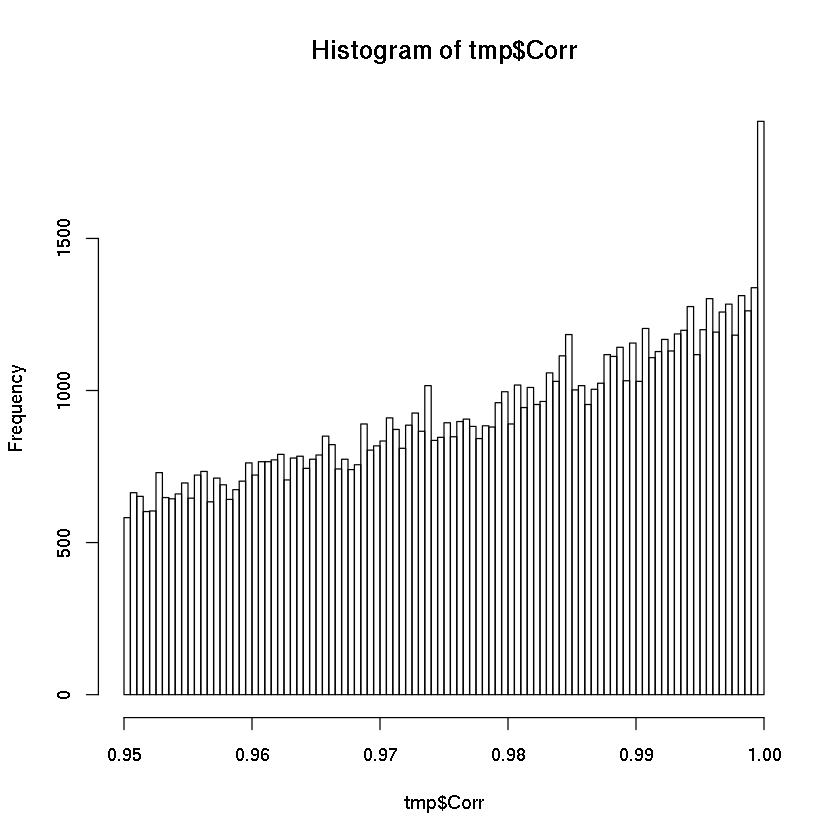

[1] 4553818       3

[1] 4553818       3

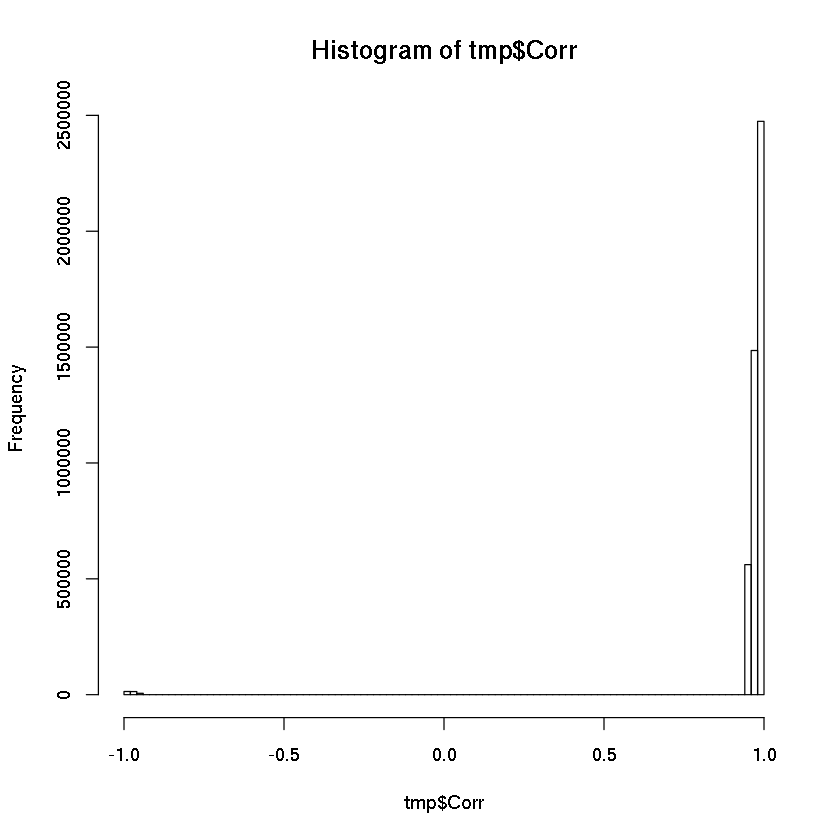

In [500]:
# now: how many significant edges can be found between
# dplyr the hell out of that
# Testing:
tmp <- gene_corr_res_sig005$Afu_alone_0h$r %>%
    data.frame(check.names = F) %>%
    mutate(Gene1 = rownames(.)) %>%
    gather("Gene2", "Corr", -Gene1) %>%
    filter(abs(Corr) > 0)

hist(tmp$Corr, breaks = 100)
dim(tmp)
dim(tmp %>% filter(abs(Corr) > 0.25))


# now: how many significant edges can be found between
# dplyr the hell out of that
# Testing:
tmp <- gene_corr_res_sig005$DC_plus_CMV_0h_plus_Afu_0h$r %>%
    data.frame(check.names = F) %>%
    mutate(Gene1 = rownames(.)) %>%
    gather("Gene2", "Corr", -Gene1) %>%
    filter(abs(Corr) > 0)

hist(tmp$Corr, breaks = 100)
dim(tmp)
dim(tmp %>% filter(abs(Corr) > 0.25))

Rho-Distribution per network

In [99]:
sig_corr_df <- read_tsv("../results/correlation/deg_genes/deg_gene_corr_sig001.tsv")

Parsed with column specification:
cols(
  Condition = col_character(),
  Gene1 = col_character(),
  Gene2 = col_character(),
  Corr = col_double()
)


In [100]:
head(sig_corr_df)

Condition,Gene1,Gene2,Corr
<chr>,<chr>,<chr>,<dbl>
Afu_alone_0h,Afu1g01540,Afu1g03200,0.9922953
Afu_alone_0h,Afu1g02820,Afu1g03380,0.9925768
Afu_alone_0h,Afu1g03200,Afu1g03380,0.9969161
Afu_alone_0h,Afu1g03380,Afu1g03720,0.9945331
Afu_alone_0h,Afu1g02820,Afu1g04040,0.9923229
Afu_alone_0h,Afu1g03380,Afu1g04040,0.9961142


In [107]:
g <- ggplot(sig_corr_df, aes(Corr, color = Condition, fill = Condition)) +
    facet_wrap( ~ Condition, nrow = 1, scale = "free") +
    geom_histogram(bins = 100) +
    scale_x_continuous(limits = c(-1, 1)) +
    theme_bw()

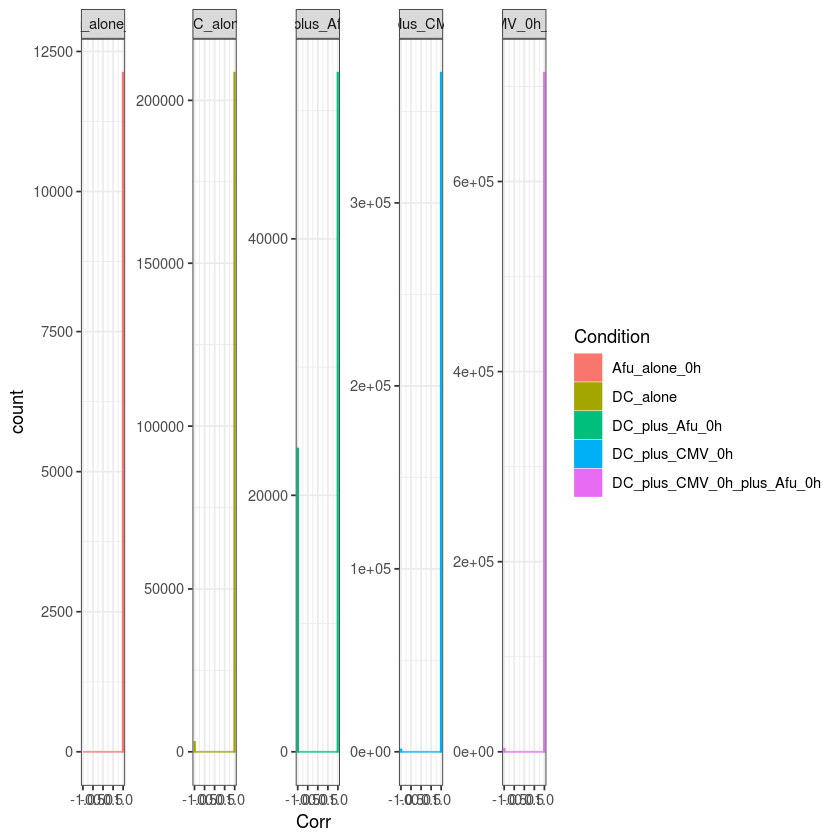

In [108]:
g

In [109]:
ggsave(paste0(outdir, "/Sig_corr_p001_rho_value_distribution.pdf"), g, width = 14, height = 7)